## <p style="text-align: right;"> &#9989; Put your name(s) here</p>

Please read though the entire project before starting!

# Homework 4 - Predicting the 2016 election by State

In this homework we are going to build an model to predict the 2016 presidential election by state. This homework is Due at 11:59pm on Friday November 4th before the election on Tuesday November 8th.  On Thursday November 10th groups will present their models and compare the predictions to the commonly accepted exit poll results (true election results are not complete until December). 

Since many of the models may make the same overall predictions, we will determine the accuracy of your prediction by each state.  

Although there will be prestige in making the most accurate predictions, your model will be graded more on your argument for the changes you make to the model and how well you implement these changes. 

### Project Components and Grading,

1. (10 points) Use git to manage your project
1. (20 points) Written description and support argument for your chosen model modifications (including references)
1. (10 points) Outline of your model code
1. (10 points) Final visualization of your predicted electorate results using red/blue state map 
1. (10 points) Final Results saved in the provided format.
1. (10 points) Final bar chart visualization of popular vote as compared to electorate vote
1. (10 points) Testing Code
1. (20 points) Final Presentation of model

As in the previous homework, you will be expected to split the work evenly between your teammates.  


----
# (10 points) Use git to manage your projects
As in the previous homeworks, you will be expected to split the work evenly between your teammates.  
    * Create a private repository in github or gitlab and include your instructor as a member.  
    * Make sure you include a copy of this notebook in the top directory of your project folder.
    * Have every person in the group make commitments. 
    * This is how you will turn in your final project. 

**Question 1**: What is the command the instructors should use to download your project?

! git pull 'git@gitlab.msu.edu:crabtr26/Election_HW.git'

----
# (20 points) Written description and support argument for your chosen model modifications (including references)

As a group you will decide how to modify the simple election model we did in class.  You will be expected to download and incorporate additional data or make a significant change to the calculation. Please refer to the following <a href="http://fivethirtyeight.com/"> fivethirtyeight.com </a> blog post:


http://fivethirtyeight.com/features/a-users-guide-to-fivethirtyeights-2016-general-election-forecast/

Part of this description is a support argument about why you think this new model will be better than the simple model we did in class.  

**Question 2**: What modifications did your group decide to make to the model. Please use a detailed description and include links for references:

We each chose to focus in on a single factor which could influence the election and then adjusted the in-class model to use each of our predictions. Jacob chose to incorporate data about the change in the unemployment rate in the year leading up to the election. Jusso chose to use data collected from the S&P500 to incorporate the influence of the overall state of the economy. Alex chose to use Twitter data which he parsed for positive and negative comments about each candidates, in a similar fashion to one of last years assignments.

**Question 3**: Why do you think your model will be a better predictor than the simple prediction we did in class?  Jjustify your answer. 

We know that elections can be difficult to predict. 

**Question 4**: It is assumed that additional data will be needed to complete your election model.  Where are you planning to get this data and how will the data be imported into Jupyter notebooks? If this assumption is false, explain the significant change you are making to the model.

Each of us incorporated additional data into the model. The data is imported into the jupyter notebook by sending requests to the websites and then scrapping the page for our data. Because of the nature of the data we used (tweets, stocks, etc) we decided to get the data directly from the webpages instead of saving them in a file. The upside to this decision is that we actually get to use real time data in our model each time it is executed, but the downside is that websites can change which could end up causing some problems. 

----
# (10 points) Outline of your model code

Write a short outline of your model code.  This should let the instructors understand the basic, high level structure of your program? i.e. what classes (if any) are you using and what order are you running your high level functions. If you do not provide enough detail the instructors can not give you partial credit.  However, if you provide too much detail it will be difficult for the instructors understand the big picture.  

Something like Seudo-code or a flow-chart would be appropriate here. 

The basic flow of our model is similar to the model we began in class. There is only a single class called election. In order to generate an election map, one must first collect online polling data by using the election.poll() method. After the poll data is collected, it can be adjusted by using any or all of the the election.apply_unemployment_data() method, the apply_market_influence() function, and the apply_twitter_influence() function. Finally, an election map is generated by feeding a poll into an election object. The basic execution of the model will look something like this:


poll = election.poll()

apply_market_influence(poll, 0.05)

apply_twitter_influence(poll)

election.apply_unemployment_data(poll)

election(poll)

----
# (10 points) Final visualization of your predicted electorate results using red/blue state map

Create a red/blue state map (like the one we did in class). Put your code below for running your model and creating the final visualization.

You are encouraged (not required) to import your code from an external python file and just put a few lines of code that calls your model. 

In [66]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, clear_output
import time  

import requests
from bs4 import BeautifulSoup

import calendar
import datetime
import urllib.request
import re
import sys
import pickle
import os.path
import scipy.misc

class election():
    '''Class to create and display a state map based on colors.'''
    
    def __init__(self, results = []):
        if results == []:
            results = election.poll()
        self.img =  scipy.misc.imread('state_labels2.png')
        #np.load('state_labels2.npy')
        self.img = self.img[:,:,0]
        self.states = election.stateList()
        self.votes = election.electorate()
        if results != []:
            self.majority_wins(results)
    
    def save_poll(filename=""):
        if filename =="":
            filename=str(datetime.date.today())+".p"
        polldata = election.poll()
        pickle.dump( polldata, open( filename, "wb" ) )
    
    def load_poll(filename=""):
        if filename =="":
            filename=str(datetime.date.today())+".p"
        if(os.path.isfile(fname)):
            polldata= pickle.load( open( filename, "rb" ) )
        return(polldata)
        
    def poll_ratings(fname='pollster-ratings.csv'):
        '''
        From: https://github.com/fivethirtyeight
        indices are as follows:
        0:ID, 1:Pollster, 2:Polls, 3:Live Caller With Cellphones, 4:Internet,
        5:NCPP/AAPOR/Roper, 6:Polls, 7:Simple Average Error, 8:Races Called Correctly,
        9:Advanced Plus-Minus, 10:Predictive Plus-Minus, 11:538 Grade, 
        12:Banned by 538, 13:Mean-Reverted Bias
        '''
        pollster_ratings = {}
        if os.path.isfile(fname):
            f = open(fname,'r')
            for line in f:
                index = 0
                for word in line.split(','):
                    if word=='ID':
                        break
                    if index==1:
                        poll = word
                    if index==7:
                        pollster_ratings[poll]=word
                        break
                    index+=1
        else:
            print("Pollster-rating file not found. Using defaults (10)")
        return pollster_ratings
    
    def poll(default_rating=10):
        all_states={}
        us_state_abbrev = election.getAbbrev()
        pollster_ratings = election.poll_ratings()
        today = datetime.date.today()
        one_day = datetime.timedelta(days=1)

        yesterday = today - one_day
        two_days_back = yesterday - one_day

        get_today =  calendar.month_name[today.month] + " " + str(today.day)
        get_day =  calendar.month_name[yesterday.month] + " " + str(yesterday.day)
        prev_get_day =  calendar.month_name[two_days_back.month] + " " + str(two_days_back.day)

        url_contents = str(urllib.request.urlopen("http://www.realclearpolitics.com/epolls/latest_polls/state/").read())
        for i in range(36):
            first_pos = url_contents.find(get_day)
            second_pos = url_contents.find(prev_get_day)

            while second_pos < 0:
                two_days_back -= one_day
                prev_get_day = calendar.month_name[two_days_back.month] + " " + str(two_days_back.day)
                second_pos = url_contents.find(prev_get_day)

            chunk = first_pos = url_contents[first_pos:second_pos]

            pattern = re.compile('(<a .*?(Clinton \+[\d]{1,2}|Trump \+[\d]{1,2}))')

            bits = re.findall( pattern, chunk )

            for bit in bits:
                new_bit = bit[0].replace( "http:", "" )
                new_bit = new_bit.replace( "https:", "" )
                pattern = re.compile( '([A-Z].*?:)' )
                election_type = re.findall( pattern, new_bit )
                if( election_type[0] == "General Election:" ):
                    election_type = "Gen"
                elif( not election_type[0][:-1] in us_state_abbrev ):
                    election_type = election_type[0][:3]
                    continue
                else:
                    election_type = us_state_abbrev.get(election_type[0][:-1])

                start = bit[0].find("http")
                find_poll = bit[0][start:start+200]
                poll_start = find_poll.find(">")
                poll_end = find_poll.find("<")
                pollster = find_poll[poll_start+1:poll_end]
                
                #Set default error to 10
                poll_err = default_rating
                for each in pollster_ratings:
                    if each.find(pollster) > -1 or pollster.find(each) > -1:
                        poll_err = float(pollster_ratings[each])

                pattern = re.compile( '(class="lp-poll.*?</a>)' )
                bits = re.findall( pattern, bit [0] )
                poll_chunk = bits[0][20:]
                first_pos = poll_chunk.find(">")
                poll_chunk = poll_chunk[first_pos+1:-4]

                split_result = bit[1].split(" ")
                perc1 = bit[0][0:-15].find(">Clinton")
                if perc1 < 0:
                    perc1 = bit[0][0:-15].find(">Trump")
                    scoreT = float(bit[0][perc1+7:perc1+9])
                    scoreC = float(bit[0][perc1+19:perc1+21])
                else:
                    scoreT = float(bit[0][perc1+19:perc1+21])
                    scoreC = float(bit[0][perc1+9:perc1+11])


                result = split_result[0][:2] + split_result[1]

                my_date = get_day[len(get_day)-2:len(get_day)]
                if my_date[0] == ' ':
                    my_date = '0' + my_date[1:3]

                if election_type not in all_states:
                    all_states[election_type] = (scoreC, scoreT, (time.strptime(get_day,"%B %d")).tm_yday,poll_err)          

            yesterday -= one_day
            two_days_back -= one_day

            get_day = calendar.month_name[yesterday.month] + " " + str(yesterday.day)
            prev_get_day =  calendar.month_name[two_days_back.month] + " " + str(two_days_back.day)

        return all_states
        
    def getAbbrev():
        us_state_abbrev = {
        'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'District of Columbia': 'DC',
        'Delaware': 'DE',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY',
        }
        return us_state_abbrev
    
    def getnames():
        abbrev = election.getAbbrev()
        names = {}
        for key in abbrev:
            names[abbrev[key]] = key
        return names
    
    #Default eleciton results (used for testing) as randomly picked using out of date polling data.
    def polldefaults():
        defaults = {
            'WA':(1,0),
            'OR':(1,0),
            'CA':(1,0),
            'NV':(1,0),
            'AK':(0,1),
            'ID':(0,1),
            'UT':(0,1),
            'AZ':(0,1),
            'MT':(0,1),
            'WY':(0,1),
            'CO':(1,0),
            'NM':(1,0),
            'HI':(1,0),
            'ND':(0,1),
            'SD':(0,1),
            'NE':(0,1),
            'KS':(0,1),
            'OK':(0,1),
            'TX':(0,1),
            'MN':(1,0),
            'IA':(1,0),
            'MO':(0,1),
            'AR':(0,1),
            'LA':(0,1),
            'WI':(1,0),
            'IL':(1,0),
            'MS':(0,1),
            'IN':(0,1),
            'KY':(0,1),
            'TN':(0,1),
            'AL':(0,1),
            'MI':(1,0),
            'OH':(1,0),
            'GA':(0,1),
            'FL':(1,0),
            'SC':(0,1),
            'NC':(1,0),
            'VA':(1,0),
            'WV':(0,1),
            'MD':(1,0),
            'DE':(1,0),
            'NJ':(1,0),
            'RI':(1,0),
            'MA':(1,0),
            'ME':(1,0),
            'NH':(1,0),
            'VT':(1,0),
            'NY':(1,0),
            'PA':(1,0),
            'CT':(1,0)
        }
        return defaults
    
    def electorate():
        votes = {}
        #Sets of dictionaries to be used with dictionaryLabelStates()
        votes['AL'] = 9
        votes['AK'] = 3
        votes['AZ'] = 11
        votes['AR'] = 6
        votes['CA'] = 55
        votes['CO'] = 9
        votes['CT'] = 7
        votes['DC'] = 3
        votes['DE'] = 3
        votes['FL'] = 29
        votes['GA'] = 16
        votes['HI'] = 4 
        votes['ID'] = 4
        votes['IL'] = 20
        votes['IN'] = 11
        votes['IA'] = 6
        votes['KS'] = 6
        votes['KY'] = 8
        votes['LA'] = 8 
        votes['ME'] = 4
        votes['MD'] = 10 
        votes['MA'] = 11
        votes['MI'] = 16
        votes['MN'] = 10
        votes['MS'] = 6
        votes['MO'] = 10
        votes['MT'] = 3
        votes['NE'] = 5
        votes['NV'] = 6
        votes['NH'] = 4
        votes['NJ'] = 14
        votes['NM'] = 5
        votes['NY'] = 29 
        votes['NC'] = 15
        votes['ND'] = 3
        votes['OH'] = 18
        votes['OK'] = 7
        votes['OR'] = 7
        votes['PA'] = 20
        votes['RI'] = 4
        votes['SC'] = 9
        votes['SD'] = 3
        votes['TN'] = 11
        votes['TX'] = 38
        votes['UT'] = 6
        votes['VT'] = 3
        votes['VA'] = 13
        votes['WA'] = 12
        votes['WV'] = 5
        votes['WI'] = 10
        votes['WY'] = 3
        return votes    
    
    def stateList():
        states ={}
        states['AK']=0
        states['AL']=1
        states['AR']=2
        states['AZ']=3
        states['CA']=4
        states['CO']=5
        states['CT']=6
        states['DC']=7
        states['DE']=8
        states['FL']=9
        states['GA']=10
        states['HI']=11
        states['IA']=12
        states['ID']=13
        states['IL']=14
        states['IN']=15
        states['KS']=16
        states['KY']=17
        states['LA']=18
        states['MA']=19
        states['MD']=20
        states['ME']=21
        states['MI']=22
        states['MN']=23
        states['MO']=24
        states['MS']=25
        states['MT']=26
        states['NC']=27
        states['ND']=28
        states['NE']=29
        states['NH']=30
        states['NJ']=31
        states['NM']=32
        states['NV']=33
        states['NY']=34
        states['OH']=35
        states['OK']=36
        states['OR']=37
        states['PA']=38
        states['RI']=39
        states['SC']=40
        states['SD']=41
        states['TN']=42
        states['TX']=43
        states['UT']=44
        states['VA']=45
        states['VT']=46
        states['WA']=47
        states['WI']=48
        states['WV']=49
        states['WY']=50
        states['border']=255
        return states
   
    def majority_wins(self,results):
        red_blue = np.zeros( (self.img.shape[0], self.img.shape[1], 3) )
        red_blue[self.img > 50,:] = [0.5,0.5,0.5]
        red_blue[self.img < 50,:] = [0.5,0.5,0.5]
        red_blue[self.img == self.states['border'],:] = [1,1,1]
        red = 0
        blue = 0
        for state in election.electorate():
            if state in results:
                polldata = results[state]
                if polldata[0] > polldata[1]:
                    blue = blue + self.votes[state]
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [0,0,1]
                elif polldata[1] > polldata[0]:
                    red = red + self.votes[state]
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [1,0,0]
                else:                       
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [0.5,0.5,0.5]
            else:
                if state in self.states:
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [0.5,0.5,0.5]
                        
        plt.figure(figsize = (10,20))
        plt.imshow(red_blue)
        plt.axis('off')
        if(red > 270):
            plt.title("Red Wins: "+str(red)+"/"+str(blue))
        elif(blue > 270):
            plt.title("Blue Wins: "+str(blue)+"/"+str(red))
        else:
            plt.title("No clear winner, Blue: "+str(blue)+" Red:"+str(red)+" --- 270 votes needed")
        return red_blue
    
    def disp_state_movie(self):
        fig, ax = plt.subplots(figsize=(10,5))
        for state in self.states:
            print(state)
            #for region in self.states[state]:
            plt.imshow(self.img == self.states[state])
            plt.title(state)

            # Animaiton part (dosn't change)
            clear_output(wait=True) # Clear output for dynamic display
            display(fig)            # Reset display
            fig.clear()             # Prevent overlapping and layered plots
            time.sleep(2)      # Sleep for a fraction of a second to allow animation to catch up

    def get_unemployment_data():
        '''Obtaining data from the Bureau for Labor Statistics. The data 
        contained is a list of states, partnered with a tuple contianing
        four floating points. The floating point values correspond to, in 
        order, the states unemployment rate from Sept. 2015, the states
        unemployment rate from Sept. 2016, the difference between the two
        unemployment rates, and the rank of the overall change in employment
        for each state.
        '''

        # Obtaining data from the website, making it easier to use
        r = requests.get('http://www.bls.gov/web/laus/laumstch.htm').text
        soup = BeautifulSoup(r, 'lxml')
        text = soup.get_text()
        lines = text.split('\n')
        useful_lines = lines[530:-109]

        # These will store the data obtained from the BLS
        data = {}
        states = []

        # Adding each state to a list
        for line in useful_lines:
             if len(line) > 3 and '.' not in line:
                states.append(line)

        # Adding the data to the database for each state
        for line in useful_lines:
            for state in states:
                index = useful_lines.index(line)
                if state in line:
                    data[state] = tuple(useful_lines[index+1:index+5])

        # Changing Dictionary keys to state Abbreviations            
        for state in states:
            abbrevs = election.getAbbrev()
            newkey = abbrevs[state]
            data[newkey] = data.pop(state)

        return data
    
    def apply_unemployment_data(poll_dictionary, show_dict = False):
        '''Using the data we found to adjust our prediction.'''
        
        data = election.get_unemployment_data()
        for state in poll_dictionary:
            clinton, trump, date, stddev = poll_dictionary[state]
        
            change = float(data[state][2])
            clinton += change
            trump -= change
            
            poll_dictionary[state] = (clinton,trump,date,stddev)
        
        if show_dict == True:
            return poll_dictionary
            
            
# Looking at S&P to gauge economic sentiment for the 2012-2016 period

import urllib.request

def get_relative_increase():
    ''' Get the relative increase of the S&P 500 during 2012-2016 '''
    try:
        with urllib.request.urlopen("http://ichart.finance.yahoo.com/table.csv?s=SPY") as data:
            data.readline() # Discard header
            latest_price = data.readline().decode("utf-8").split(",")[1]
            def get_earlier():
                line = data.readline().decode("utf-8").split(",")
                year = line[0].split("-")[0]
                price = line[1]
                return year, price
            year, earliest_price = get_earlier()
            while int(year) > 2011:
                year, earliest_price = get_earlier()
            return float(latest_price) / float(earliest_price)
    except:
        print("Failed reading yahoo finance data")
        return None
    
def get_market_influence(conservative_growth):
    ''' Returns a factor by which to favor the current (positive result) or the opposite party
        (negative result) based on the increase of the S&P500 compared to the given
        yearly conservative rate of growth.
        
        E.g. if the S&P went up at 10% a year compared to a conservative baseline of 5%, 
        we would weight the current party by 5% over the opposite party.
    '''
    p = get_relative_increase()
    if p == None:
        return 0
    # We (approximately) have p = (1 + r)^4 -> r = p^(1/4) - 1. 4 being the 4 years of a presidential term
    r = p**(1/4) - 1
    return r - conservative_growth
    
       
def apply_market_influence(poll_dictionary, conservative_growth):
    ''' poll_dictionary is the dictionary returned by election.poll() in the Nate Silver code. 
        conservative_growth is an estimate for yearly returns of the S&P 500, on the order of 0.05-0.06.
        
        This function will shift the polling results depending on the growth of the S&P.'''
    
    influence = get_market_influence(conservative_growth)
    for state in poll_dictionary:
        clinton, trump, date, stddev = poll_dictionary[state]
        total = clinton + trump
        shift = total * influence
        # The current party in the white house is democratic, so we keep the sign for clinton and
        # flip it for trump, i.e. if the influence is negative, trump will get more votes.
        clinton += shift
        trump -= shift
        poll_dictionary[state] = (clinton, trump, date, stddev)
        
##TESTS##

# Make sure the market influence code doesn't blow up for weird numbers and input dictionaries

#1. 
apply_market_influence({}, 0.05)

#2.
apply_market_influence({'WA' : (0, 0, 0, 0)}, 0.05)

#3.
apply_market_influence({'WA' : (100, 100, 0, 0)}, 10)

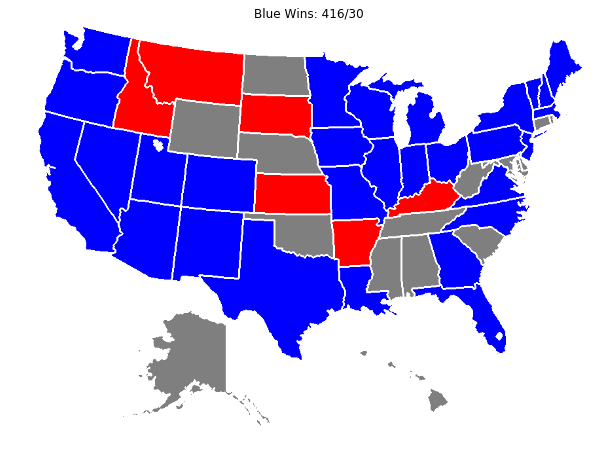

In [2]:
poll = election.poll()
apply_market_influence(poll, 0.05)
election.apply_unemployment_data(poll)
election(poll)

----
# (10 points) Final Results saved in the provided format.

Save your final inputs and output predictions to appropriate files.  

**For input files:** If you download any data from a changing website, make sure you save a copy of that data in a local file checked into your repository. Make sure you include code in your model to read these files and use them in case the changing website is different or disabled during grading.  

**For Visualizations:** For each of your predictions (only one is required), save a copy of your final visualizations (both red/blue state maps and bar graphs) as image files and save them in your git repository. 

**For prediction data:** For each of your predictions (only one is required), create a python dictionary with the state abbreviations as the key and a tuple as the values.  The tuples should be in the alphabetical formate predictions for the candidates as numbers between zero and one (representing the percent of the popular vote in the state).  For example:


In [19]:
import pickle
cwd = os.getcwd()
filename = cwd.replace('Election_HW', 'prediction.p')

poll = election.poll()
unemployment_data = election.get_unemployment_data()
apply_market_influence(poll, 0.05)
election.apply_unemployment_data(unemployment_data, poll)
prediction = election.apply_unemployment_data(unemployment_data, poll, show_dict = True)

pickle.dump(prediction, open(filename, "wb" ) )

Your instructors can then read the file using their own code in a format similar to the following:

In [20]:
group_prediction = pickle.load( open( filename, "rb" ) )
print(group_prediction)

{'NM': (53.93804148014361, 35.06195851985639, 308, 10), 'WI': (49.94516181316602, 32.05483818683398, 308, 9.705), 'NV': (49.19213276599115, 42.80786723400885, 306, 10), 'NJ': (58.90743567070863, 32.09256432929137, 308, 4.468001), 'GA': (52.96152695655616, 41.03847304344384, 308, 10), 'IN': (46.45334438486109, 41.54665561513891, 308, 5.804545), 'AR': (35.94516181316602, 46.05483818683398, 307, 10), 'NY': (61.11455600373104, 22.88544399626896, 292, 5.331666), 'TX': (48.1380414801436, 40.8619585198564, 307, 10), 'MO': (45.73804148014361, 43.26195851985639, 306, 7.877353), 'CO': (55.70743567070863, 35.29256432929137, 308, 10), 'AK': (40.813493765058375, 30.186506234941625, 281, 10), 'ID': (34.92167633675346, 42.07832366324654, 301, 5.29653), 'OH': (48.76864728957858, 38.23135271042142, 306, 4.664438), 'NH': (50.65334438486109, 37.34665561513891, 308, 10), 'UT': (36.55940247921084, 31.44059752078916, 307, 5.488592), 'LA': (42.914556003731036, 41.085443996268964, 303, 6.653334), 'MT': (33.32

----
# (10 points) Final bar chart visualization of popular vote as compared to electorate vote

Make a second visualization of your results using a two color bar chart similar to the bar chart shown at the top of the http://projects.fivethirtyeight.com/2016-election-forecast website.  Generate two bars; one showing the electorate vote and the second showing the popular vote.  



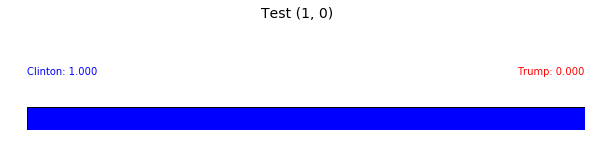

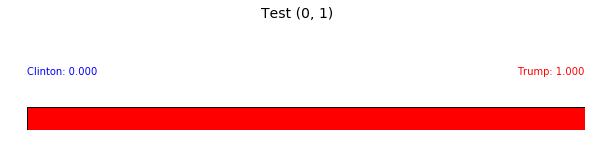

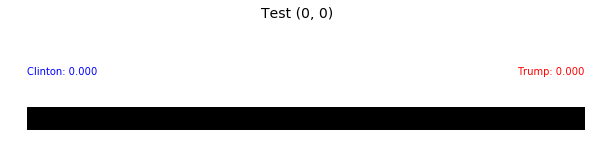

In [61]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def calculate_electorate_ratio(p):
    ''' Calculate the proportions of a 100% (1.0) that each of Clinton and Trump will take,
        assuming a winner-take-all system. E.g. if the candidates tied, this would return (0.5, 0.5).
        
        The election is founded on just as much mathematical rigor as we'd expect, and the way
        a tie would be handled would depend on that specific state. 
        
        (https://www.archives.gov/federal-register/electoral-college/faq.html#statetie)
        
        For our purposes, we'll just split the votes in half (fair enough?).
        '''
    electorate = election.electorate()
    clinton_tot = 0
    trump_tot = 0
    for state in p:
        clinton, trump, _, _ = p[state]
        if clinton == trump:
            half = floor(electorate[state]/2)
            clinton_tot += half
            trump_tot += half
        elif clinton > trump:
            clinton_tot += electorate[state]
        else:
            trump_tot += electorate[state]
    total = clinton_tot + trump_tot
    return (clinton_tot / total, trump_tot / total)

def calculate_popular_vote_ratio(p):
    ''' Return the raw proportion of total votes for Clinton and Trump. '''
    clinton_tot = 0
    trump_tot = 0
    for state in p:
        clinton, trump, _, _ = p[state]
        clinton_tot += clinton
        trump_tot += trump
    total = clinton_tot + trump_tot
    return (clinton_tot / total, trump_tot / total)

def draw_bar(blue_to_red, width, height, title):
    ''' Draw a horizontal bar chart that displays the vote proportions for each candidate. '''
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    if blue_to_red == (0, 0):
        ax1.add_patch(
            patches.Rectangle(
                (0, 0), 
                width,     
                height,
                fc = 'black'
            )
        )
    else:
        ax1.add_patch(
            patches.Rectangle(
                (0, 0), 
                width * blue_to_red[0],     
                height,
                fc = 'b'
            )
        )
        ax1.add_patch(
            patches.Rectangle(
                (width * blue_to_red[0], 0), 
                width * blue_to_red[1],     
                height,
                fc = 'r'
            )
        )
    plt.text(0, 0.5, ("Clinton: %.3f" % blue_to_red[0]), color = 'b')
    plt.text(0.8775, 0.5, ("Trump: %.3f" % blue_to_red[1]), color = 'r')
    plt.axis('off')
    fig1.set_size_inches(10, 2)
    fig1.suptitle(title, fontsize=14)
    plt.show(fig1)
    
##TEST## Make sure the code still runs properly in edge cases

#1. (1, 0) as the ratios
draw_bar((1, 0), 1, 0.2, "Test (1, 0)")

#2. (0, 1) as the ratios
draw_bar((0, 1), 1, 0.2, "Test (0, 1)")

#3. (0, 0) as the ratios
draw_bar((0, 0), 1, 0.2, "Test (0, 0)")


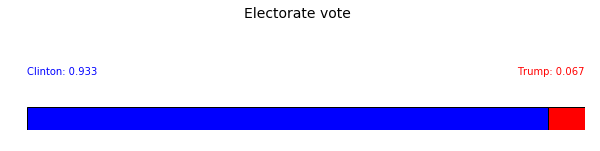

In [55]:
draw_bar(calculate_electorate_ratio(poll), 1, 0.2, "Electorate vote")

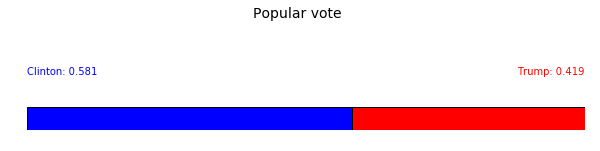

In [56]:
draw_bar(calculate_popular_vote_ratio(poll), 1, 0.2, "Popular vote")

----
# (10 points) Testing Code

Make sure your code is well tested.  Please include at least 3 testing setup you used to help test and validate your code for each section.  Include a print statement on what exactly each code is testing. 


I will be looking for completeness. Try to write at least one test for each function, class and each method in each class.  

Note, it may be easier for you to integrate your testing in the code generated in the above functions. Please make sure you clearly label all tests so your instructors can see what you are doing.  It may be helpful to use a keyword such as ##TEST##. 

In [ ]:
##TEST## Put your additional test code here. 

----
# (20 points) Final Presentation of model

On November 10th your group will present your model to the class.  Your group will be given a maximum of 10 minutes. Each member of the group is expected to explain their portion of the project.  

Please include any visualizations you would like to use in your git repository.  At the very least image files of your final predictions will likely be useful.  I will have each repository downloaded to my computer and ready for presentation.  I also recommend using a Jupyter notebook to organize your visualizations. 

----

### Turning in your homework

Now, you need to submit this assignment by uploading this jupyter notebook file to the course Desire2Learn web page. Instructors will use this file to motivate downloading of your git repository and grading of your homework. This means we will have two identical copies of this notebook (one in D2L and one in your git repository).  Each group must only submit one file to D2L.   

Don't forget to add your names in the first cell.  Turn in all files using the "Homework assignments" folder, find the dropbox link for "HW4-Election", and upload it there.